In [ ]:
from scipy.integrate import odeint
import time
import math
import numpy as np
from math import *
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from IPython.display import HTML
import import_ipynb
import Functions_for_modeltest
import os
import seaborn as sns

In [8]:
#Filepaths to excel for USB stick
test1_initials = r'D:\Double Pendulum\Parameterstudy\Test1_initials'
test2_initials = r'D:\Double Pendulum\Parameterstudy\Test2_initials'
test1_params = r'D:\Double Pendulum\Parameterstudy\Test1_params'
test2_params = r'D:\Double Pendulum\Parameterstudy\Test2_params'

test_list_initials = [test1_initials, test2_initials]
test_list_params = [test1_params, test2_params]

In [9]:
#######################################################################################################################################################
## Now all the filepaths to the ML-Models / PINNs
multi_inits_model_paths = r'D:\Double Pendulum\Parameterstudy'

Model_pathlist = [multi_inits_model_paths]
#######################################################################################################################################################

Lagrange_3_3000x1_Anfangsbedingung = 'Lagrange_3_3000x1_Anfangsbedingung'
Energieerhaltung_3_3000x1_Anfangsbedingung = 'Energieerhaltung_3_3000x1_Anfangsbedingung'
Lagrange_7_1000x7_2000x1_Anfangsbedingung = 'Lagrange_7_1000x7_2000x1_Anfangsbedingung'
Energieerhaltung_7_1000x7_2000x1_Anfangsbedingung = 'Energieerhaltung_7_1000x7_2000x1_Anfangsbedingung'
Lagrange_7_1000x7_Anfangsbedingung = 'Lagrange_7_1000x7_Anfangsbedingung'
Energieerhaltung_7_1000x7_Anfangsbedingung = 'Energieerhaltung_7_1000x7_Anfangsbedingung'
Lagrange_3_3000x1_Modellparameter = 'Lagrange_3_3000x1_Modellparameter'
Energieerhaltung_3_3000x1_Modellparameter = 'Energieerhaltung_3_3000x1_Modellparameter'
Lagrange_8_700x8_6000x1_Modellparameter = 'Lagrange_8_700x8_6000x1_Modellparameter'
Energieerhaltung_8_700x8_6000x1_Modellparameter = 'Energieerhaltung_8_700x8_6000x1_Modellparameter'
Lagrange_8_700x8_Modellparameter = 'Lagrange_8_700x8_Modellparameter'
Energieerhaltung_8_700x8_Modellparameter = 'Energieerhaltung_8_700x8_Modellparameter'

Model_list_sorted = [[[Lagrange_3_3000x1_Anfangsbedingung, 3], [Energieerhaltung_3_3000x1_Anfangsbedingung, 3], [Lagrange_7_1000x7_2000x1_Anfangsbedingung, 7], [Energieerhaltung_7_1000x7_2000x1_Anfangsbedingung, 7], [Lagrange_7_1000x7_Anfangsbedingung, 7], [Energieerhaltung_7_1000x7_Anfangsbedingung, 7],
          [Lagrange_3_3000x1_Modellparameter, 3], [Energieerhaltung_3_3000x1_Modellparameter, 3], [Lagrange_8_700x8_6000x1_Modellparameter, 8], [Energieerhaltung_8_700x8_6000x1_Modellparameter, 8], [Lagrange_8_700x8_Modellparameter, 8], [Energieerhaltung_8_700x8_Modellparameter, 8]]]

Model_names = [['Lagrange_3_3000x1_Anfangsbedingung', 'Energieerhaltung_3_3000x1_Anfangsbedingung', 'Lagrange_7_1000x7_2000x1_Anfangsbedingung', 'Energieerhaltung_7_1000x7_2000x1_Anfangsbedingung', 'Lagrange_7_1000x7_Anfangsbedingung', 'Energieerhaltung_7_1000x7_Anfangsbedingung'],
               ['Lagrange_3_3000x1_Modellparameter', 'Energieerhaltung_3_3000x1_Modellparameter', 'Lagrange_8_700x8_6000x1_Modellparameter', 'Energieerhaltung_8_700x8_6000x1_Modellparameter', 'Lagrange_8_700x8_Modellparameter', 'Energieerhaltung_8_700x8_Modellparameter']]


In [ ]:
def calculate_mae_std_and_outliers(test_dataframes):
    dev_list_theta = []
    dev_list_omega = []

    for df in test_dataframes:
        #MAE calculation
        theta1_dev = abs(df['theta1_actual'] - df['theta1_predicted'])
        theta2_dev = abs(df['theta2_actual'] - df['theta2_predicted'])
        omega1_dev = abs(df['omega1_actual'] - df['omega1_predicted'])
        omega2_dev = abs(df['omega2_actual'] - df['omega2_predicted'])
        
        deviations_theta = np.concatenate([theta1_dev, theta2_dev])
        deviations_omega = np.concatenate([omega1_dev, omega2_dev])

        dev_list_theta.append(deviations_theta)
        dev_list_omega.append(deviations_omega)

    return dev_list_theta, dev_list_omega

In [ ]:
def csv_interpreter(filepath_excel, Model_list):
    tested_model_name = []
    deviation_model_theta = []
    deviation_model_omega = []
    
    for i in range(len(Model_list)):
        for model in Model_list[i]:
            tested_excellist = []
            filename_model = model[0]
            model_layers = model[1]
            for j in range(0, 7):
                testcycle_filename_model = f'test_nr_{j+1}_{filename_model}.csv'
                full_path_excel = os.path.join(filepath_excel, testcycle_filename_model)
                    
                # laod CSV
                df = pd.read_csv(full_path_excel)
                tested_excellist.append(df)
            
            dev_list_theta, dev_list_omega = calculate_mae_std_and_outliers(tested_excellist)
            
            combined_theta = np.concatenate(dev_list_theta)
            combined_omega = np.concatenate(dev_list_omega)
            
            deviation_model_theta.append(dev_list_theta)
            deviation_model_omega.append(dev_list_omega)
            
            tested_model_name.append(filename_model)

            
    return tested_model_name, deviation_model_theta, deviation_model_omega

In [12]:
test1_initials_tested_model_name, test1_initials_tested_theta, test1_initials_tested_omega = csv_interpreter(test1_initials, Model_list_sorted)
test2_initials_tested_model_name, test2_initials_tested_theta, test2_initials_tested_omega = csv_interpreter(test2_initials, Model_list_sorted)
test1_params_tested_model_name, test1_params_tested_theta, test1_params_tested_omega = csv_interpreter(test1_params, Model_list_sorted)
test2_params_tested_model_name, test2_params_tested_theta, test2_params_tested_omega = csv_interpreter(test2_params, Model_list_sorted)

In [13]:
filepath_excel = test1_initials
model = Model_list_sorted[0][0]
filename_model = model[0]
model_layers = model[1] 
j = 0
testcycle_filename_model = f'test_nr_{j+1}_{filename_model}.csv'
full_path_excel = os.path.join(filepath_excel, testcycle_filename_model)

df = pd.read_csv(full_path_excel)
df.head()

,time,theta1_actual,omega1_actual,theta2_actual,omega2_actual,energy_actual,m1,m2,l1,l2,dt,theta1_predicted,omega1_predicted,theta2_predicted,omega2_predicted,energy_predicted
0,0.000000,-0.207831,-0.196050,0.540463,1.025970,48.294217,2.0,1.0,1.4,1.0,0.033289,-0.207831,-0.196050,0.540463,1.025970,48.294217
1,0.033333,-0.212685,-0.096006,0.570069,0.752141,48.294019,2.0,1.0,1.4,1.0,0.033289,-0.212685,-0.096006,0.570069,0.752141,48.294019
2,0.066667,-0.214253,0.001426,0.590542,0.477379,48.293892,2.0,1.0,1.4,1.0,0.033289,-0.214253,0.001426,0.590542,0.477379,48.293892
3,0.100000,-0.212614,0.096751,0.601853,0.201883,48.293844,2.0,1.0,1.4,1.0,0.033289,-0.212614,0.096751,0.601853,0.201883,48.293844
4,0.133333,-0.207826,0.190657,0.603978,-0.074336,48.293873,2.0,1.0,1.4,1.0,0.033289,-0.207826,0.190657,0.603978,-0.074336,48.293873


Order of the called CSV files

In [25]:
Model_names = ['Lagrange_3_3000x1_Anfangsbedingung', 'Energieerhaltung_3_3000x1_Anfangsbedingung', 'Lagrange_7_1000x7_2000x1_Anfangsbedingung', 'Energieerhaltung_7_1000x7_2000x1_Anfangsbedingung', 'Lagrange_7_1000x7_Anfangsbedingung', 'Energieerhaltung_7_1000x7_Anfangsbedingung', 'Lagrange_3_3000x1_Modellparameter', 'Energieerhaltung_3_3000x1_Modellparameter', 'Lagrange_8_700x8_6000x1_Modellparameter', 'Energieerhaltung_8_700x8_6000x1_Modellparameter', 'Lagrange_8_700x8_Modellparameter', 'Energieerhaltung_8_700x8_Modellparameter']

Heatmap functions with and without theshold and call



In [ ]:
def plot_combined_heatmap(model_names, deviation_test1_theta, deviation_test2_theta, deviation_test1_omega, deviation_test2_omega, title, plot_size):

    # Calculate MAE for Theta
    mean_deviation_test1_theta = [np.mean(np.abs(np.concatenate(dev))) for dev in deviation_test1_theta]
    mean_deviation_test2_theta = [np.mean(np.abs(np.concatenate(dev))) for dev in deviation_test2_theta]

    # Claulcate MAE for Omega
    mean_deviation_test1_omega = [np.mean(np.abs(np.concatenate(dev))) for dev in deviation_test1_omega]
    mean_deviation_test2_omega = [np.mean(np.abs(np.concatenate(dev))) for dev in deviation_test2_omega]

    # Data prep for HEatmap
    data = {
        'Theta Test 1': mean_deviation_test1_theta,
        'Omega Test 1': mean_deviation_test1_omega,
        'Theta Test 2': mean_deviation_test2_theta,
        'Omega Test 2': mean_deviation_test2_omega
    }
    
    'axis labeling'
    model_names_numbered = [f"{i+1}. {name}" for i, name in enumerate(model_names)]
    df = pd.DataFrame(data, index=model_names_numbered)

    # Heatmap  creation
    plt.figure(figsize=plot_size)
    sns.heatmap(df, annot=True, cmap='RdYlGn_r', fmt='.4f')
    plt.title(title)
    plt.ylabel('Modell')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_combined_heatmap_with_dual_threshold(model_names, deviation_test1_theta, deviation_test2_theta, deviation_test1_omega, deviation_test2_omega, title, plot_size, threshold1, threshold2):

    # calculation of MAE
    mean_deviation_test1_theta = [np.mean(np.abs(np.concatenate(dev))) for dev in deviation_test1_theta]
    mean_deviation_test2_theta = [np.mean(np.abs(np.concatenate(dev))) for dev in deviation_test2_theta]
    mean_deviation_test1_omega = [np.mean(np.abs(np.concatenate(dev))) for dev in deviation_test1_omega]
    mean_deviation_test2_omega = [np.mean(np.abs(np.concatenate(dev))) for dev in deviation_test2_omega]

    # data preparation for Heatmap
    data = {
        r'1. $\theta_{MAE}$ in rad': mean_deviation_test1_theta,
        r'1. $\dot{\theta}_{MAE}$ in rad/s': mean_deviation_test1_omega,
        r'2. $\theta_{MAE}$ in rad': mean_deviation_test2_theta,
        r'2. $\dot{\theta}_{MAE}$ in rad/s': mean_deviation_test2_omega
    }
    model_names_numbered = [f"{i+1}. {name}" for i, name in enumerate(model_names)]
    df = pd.DataFrame(data, index=model_names_numbered)

    # Heatmap creation
    plt.figure(figsize=plot_size)
    ax = sns.heatmap(df, annot=True, cmap='RdYlGn_r', fmt='.4f', cbar_kws={'label': 'Mittlere absolute Abweichung in rad oder rad/s je nach Zelle'})  # Legende für Farbverlauf
    wrapped_title = textwrap.fill(title, width=60) # adjust the width
    plt.title(wrapped_title, fontsize=16, loc='center', pad=20)
    
    # plt.title(title,loc='right', pad=20, fontsize=16)	
    plt.ylabel('Modelltypen', fontsize=14)

    # marking the threshold areas
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if df.iloc[i, j] > threshold2:
                ax.add_patch(Rectangle((j, i), 1, 1, fill=False, hatch='---', linewidth=2)) # mark type
            elif df.iloc[i, j] > threshold1:
                ax.add_patch(Rectangle((j, i), 1, 1, fill=False, hatch='//', linewidth=1)) # mark type

    plt.yticks(rotation=0)
    plt.tick_params(axis='y', which='major', pad=10)
    plt.tight_layout()
    plt.show()


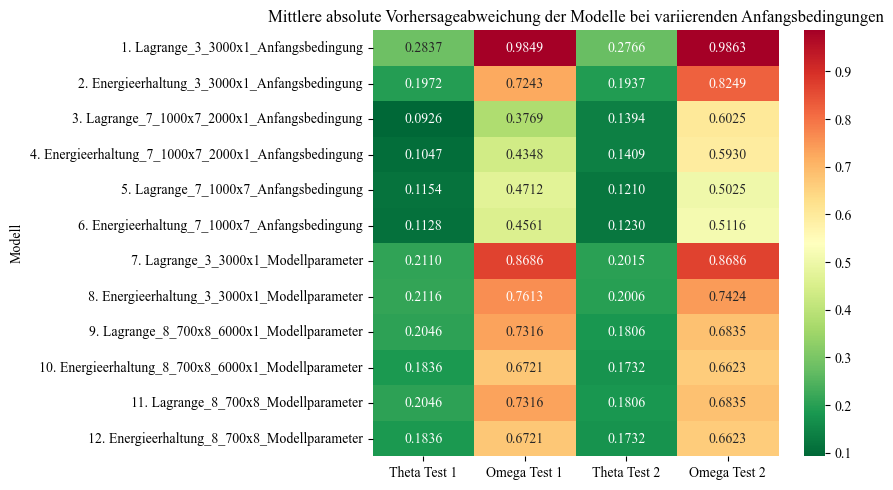

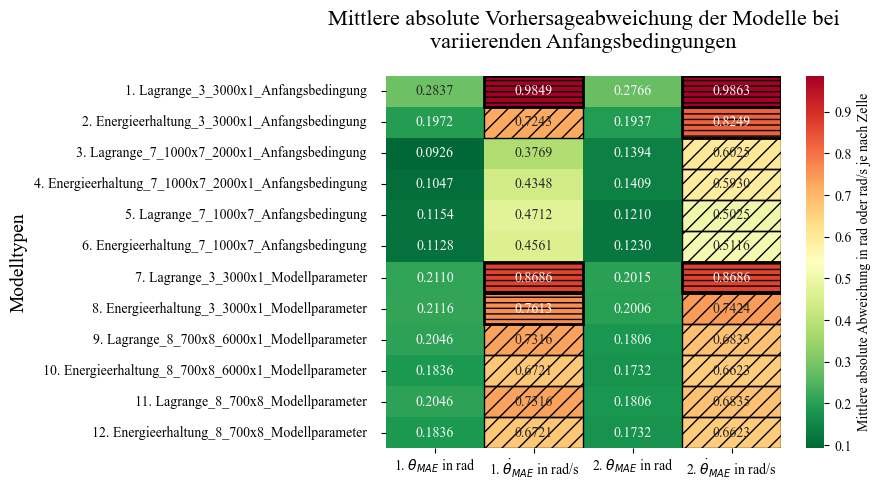

In [ ]:
plottitle = 'Mittlere absolute Vorhersageabweichung der Modelle bei variierenden Anfangsbedingungen'
plotsize = (9, 5)
threshold = 0.5
threshold2 = 0.75
plot_combined_heatmap(Model_names, test1_initials_tested_theta, test2_initials_tested_theta, test1_initials_tested_omega, test2_initials_tested_omega, plottitle,plotsize)
# plot_combined_heatmap_with_threshold(Model_names, test1_initials_tested_theta, test2_initials_tested_theta, test1_initials_tested_omega, test2_initials_tested_omega, plottitle,plotsize, threshold)
plot_combined_heatmap_with_dual_threshold(Model_names, test1_initials_tested_theta, test2_initials_tested_theta, test1_initials_tested_omega, test2_initials_tested_omega, plottitle,plotsize, threshold, threshold2)

In [ ]:
def subplotter(ax, data, title, steps=100):
    """
    Plottet die Pendelbewegung in einem Subplot.
    """
    u0 = data['theta1_actual'].values  # theta_1
    u1 = data['omega1_actual'].values # omega 1
    u2 = data['theta2_actual'].values # theta_2
    u3 = data['omega2_actual'].values # omega_2

    up0 = data['theta1_predicted'].values # theta_1
    up1 = data['omega1_predicted'].values # omega 1
    up2 = data['theta2_predicted'].values # theta_2
    up3 = data['omega2_predicted'].values # omega_2

    m1 = data['m1'].values[0]
    m2 = data['m2'].values[0]
    l1 = data['l1'].values[0]
    l2 = data['l2'].values[0]

    x1 = l1 * np.sin(u0)
    y1 = -l1 * np.cos(u0)
    x2 = x1 + l2 * np.sin(u2)
    y2 = y1 - l2 * np.cos(u2)

    xp1 = l1 * np.sin(up0)
    yp1 = -l1 * np.cos(up0)
    xp2 = xp1 + l2 * np.sin(up2)
    yp2 = yp1 - l2 * np.cos(up2)

    ax.plot(x2[0:steps], y2[0:steps], color='r', label='Simuliert')
    ax.plot(xp2[0:steps], yp2[0:steps], color='g', label='Vorhergesagt')
    ax.set_title(title)
    ax.set_xlabel('x in m')
    ax.set_ylabel('y in m')
    ax.legend( loc = "upper center")

def OneStep(data, data_threshold1, data_threshold2, titles, plottitle, steps=100):
    #create plot
    fig, axs = plt.subplots(1, 3, figsize=(9, 3)) 
    
    fig.suptitle(plottitle, fontsize=16)

    title, title1, title2 = titles

    subplotter(axs[0], data, title, steps)
    subplotter(axs[1], data_threshold1, title1, steps)
    subplotter(axs[2], data_threshold2, title2, steps)

    axs[1].set_ylabel("")
    axs[2].set_ylabel("")
    
    # plt.subplots_adjust(top=0.75)
    plt.tight_layout(rect=[0, 0.03, 1, 1.05])
    plt.show()


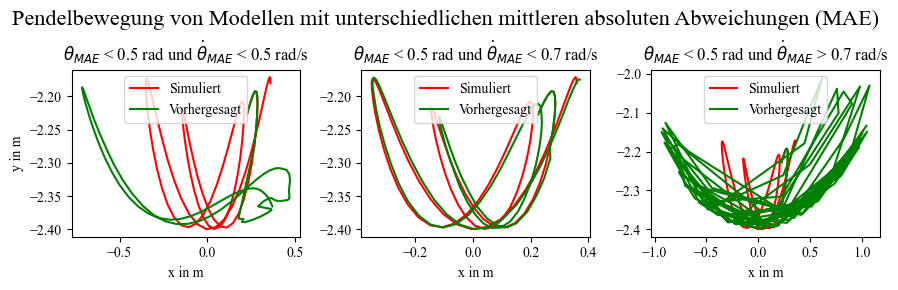

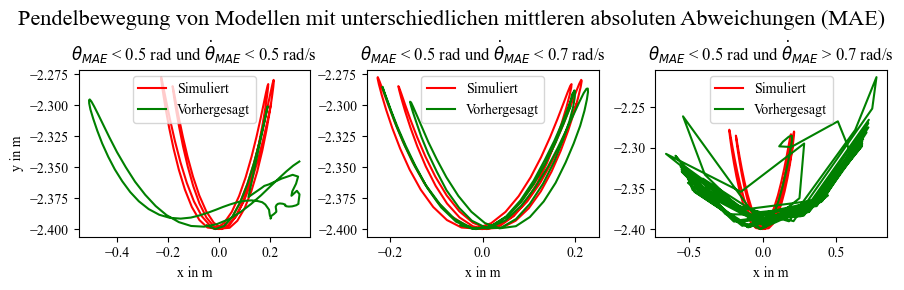

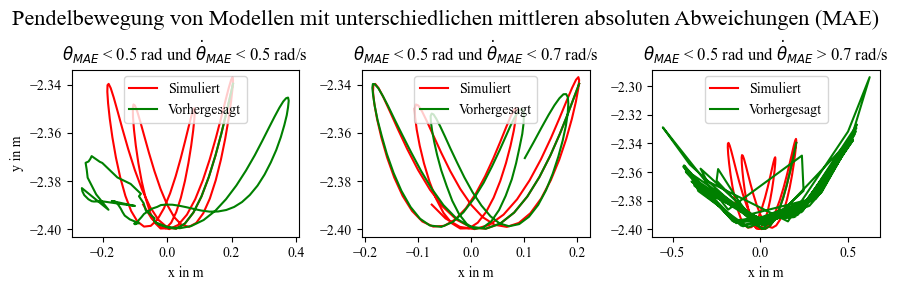

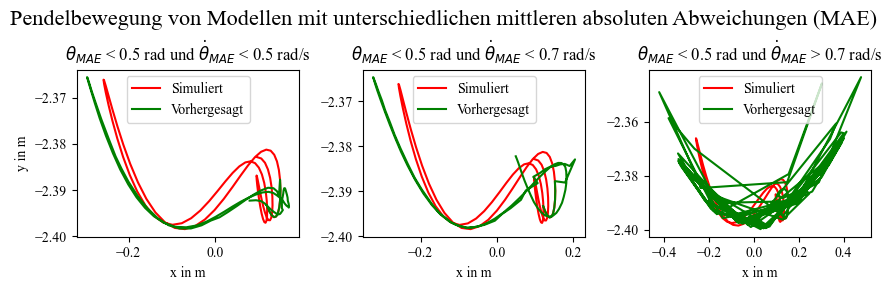

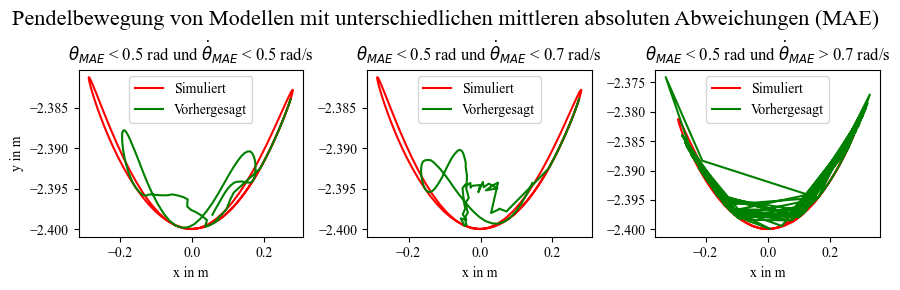

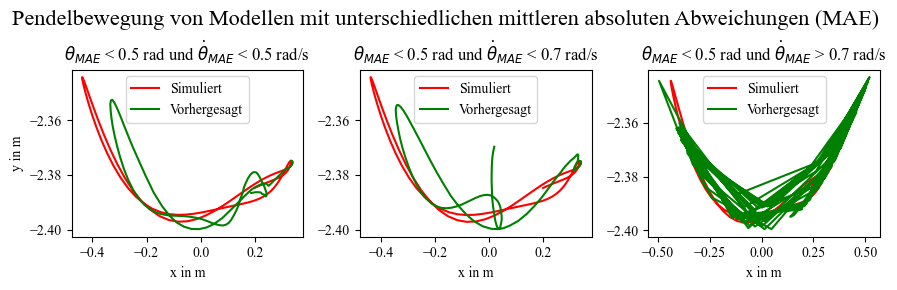

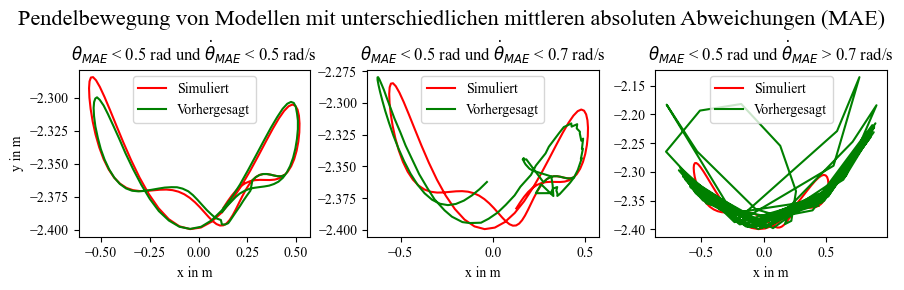

In [ ]:
# filename_model = 'mixed_initial_2000multi_inits_lagrange_MSE_1000x7'
filename_model ='multi_inits_absolute_energy_conserv_MSE_1000x7'
filename_model_threshold1 = 'mixed_6000_energy_conserv_700x8'
filename_model_threshold2 = '3layer_3000_epochs_multi_inits_absolute_energy'

filepath_excel = test1_initials  # Ersetzen Sie dies durch Ihren tatsächlichen Pfad
filepath_excel_threshold1 = test1_initials
filepath_excel_threshold2 = test1_initials

titles = [
        r'$\theta_{MAE}$ < 0.5 rad und $\dot{\theta}_{MAE}$ < 0.5 rad/s',
        r'$\theta_{MAE}$ < 0.5 rad und $\dot{\theta}_{MAE}$ < 0.7 rad/s',
        r'$\theta_{MAE}$ < 0.5 rad und $\dot{\theta}_{MAE}$ > 0.7 rad/s'
    ]
# titles = ['MAE < 0.5', '0.5 < MAE < 0.75', 'MAE > 0.75']
plottitle = 'Pendelbewegung von Modellen mit unterschiedlichen mittleren absoluten Abweichungen (MAE)'

for j in range(0, 7):
    testcycle_filename_model = f'test_nr_{j+1}_{filename_model}.csv'
    testcycle_filename_model_threshold1 = f'test_nr_{j+1}_{filename_model_threshold1}.csv'
    testcycle_filename_model_threshold2 = f'test_nr_{j+1}_{filename_model_threshold2}.csv'

    full_path_excel = os.path.join(filepath_excel, testcycle_filename_model)
    full_path_excel_threshold1 = os.path.join(filepath_excel_threshold1, testcycle_filename_model_threshold1)
    full_path_excel_threshold2 = os.path.join(filepath_excel_threshold2, testcycle_filename_model_threshold2)

    try:
        # Excel-Datei laden
        df = pd.read_csv(full_path_excel)
        df_threshold1 = pd.read_csv(full_path_excel_threshold1)
        df_threshold2 = pd.read_csv(full_path_excel_threshold2)
        OneStep(df, df_threshold1, df_threshold2, titles, plottitle)

    except FileNotFoundError:
        print(f"Datei nicht gefunden: {full_path_excel}")

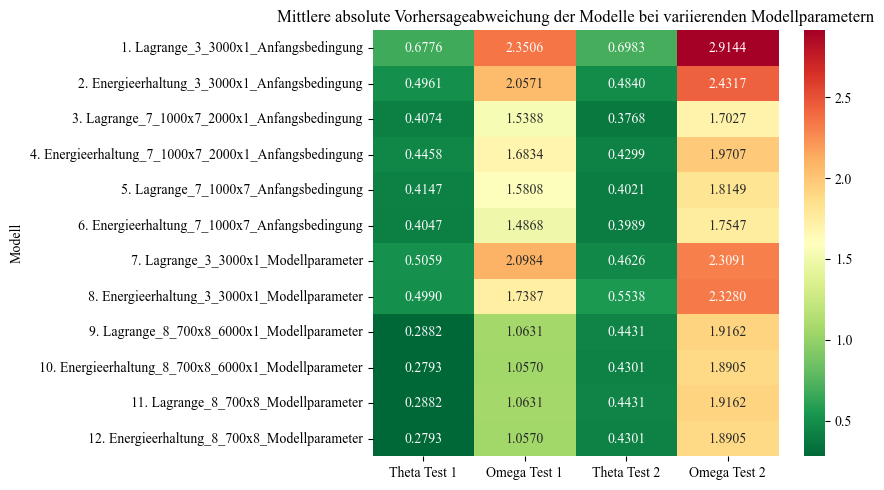

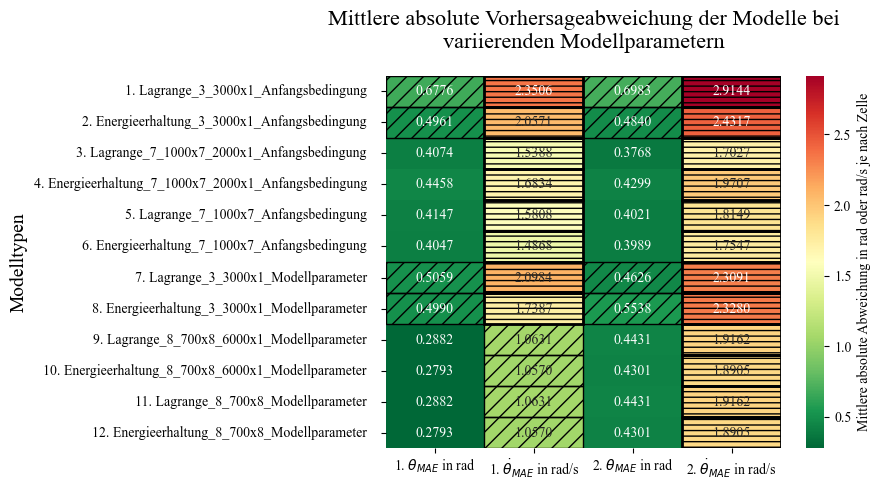

In [ ]:
plottitle = 'Mittlere absolute Vorhersageabweichung der Modelle bei variierenden Modellparametern'
plotsize = (9, 5)
threshold = 0.45
threshold2 = 1.1
plot_combined_heatmap(Model_names,  test1_params_tested_theta, test2_params_tested_theta, test1_params_tested_omega, test2_params_tested_omega, plottitle,plotsize)
# plot_combined_heatmap_with_threshold(Model_names,  test1_params_tested_theta, test2_params_tested_theta, test1_params_tested_omega, test2_params_tested_omega, plottitle,plotsize, threshold)
plot_combined_heatmap_with_dual_threshold(Model_names,  test1_params_tested_theta, test2_params_tested_theta, test1_params_tested_omega, test2_params_tested_omega, plottitle,plotsize, threshold, threshold2)

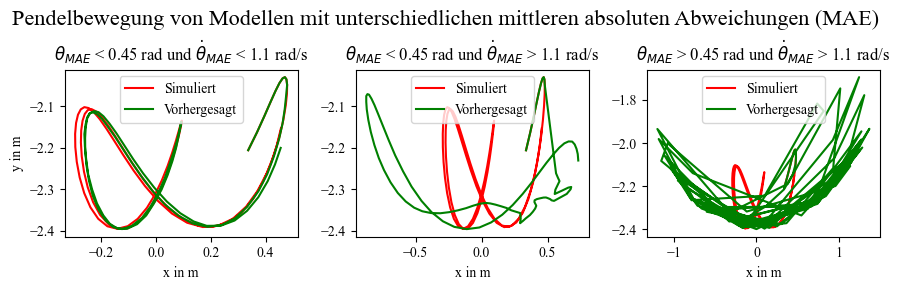

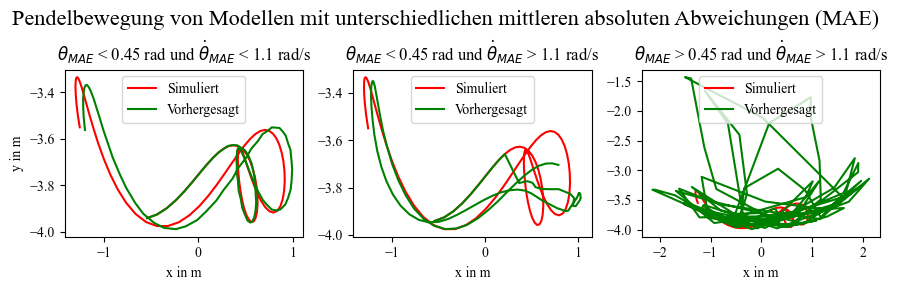

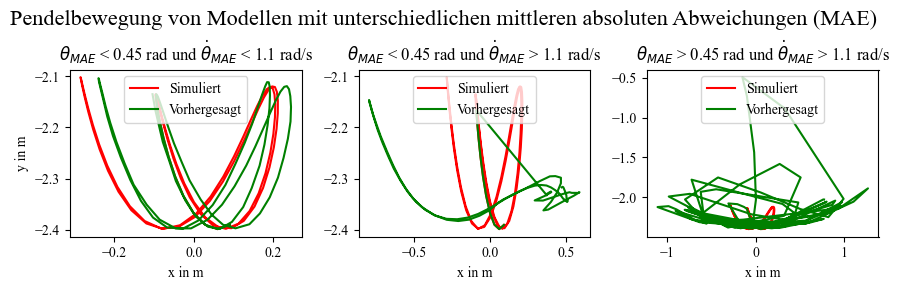

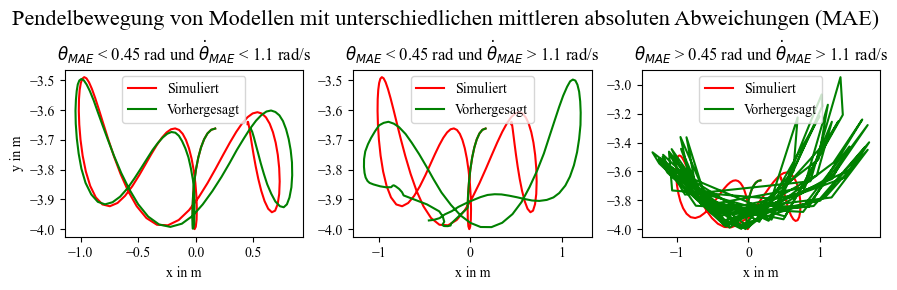

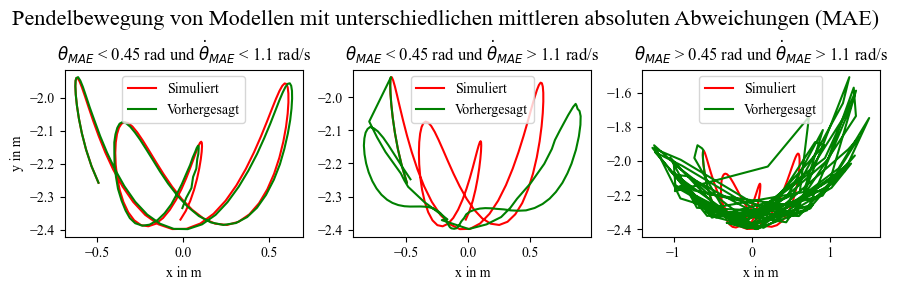

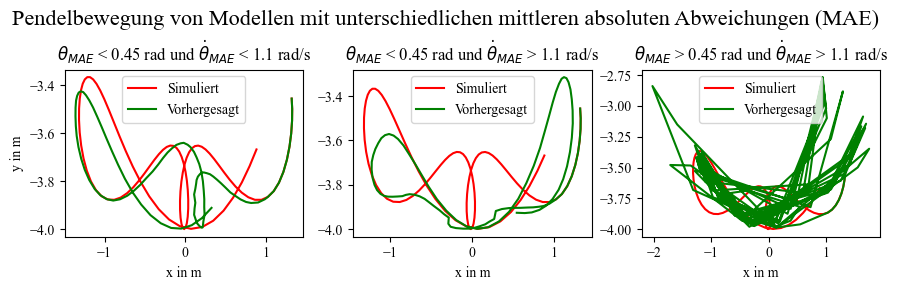

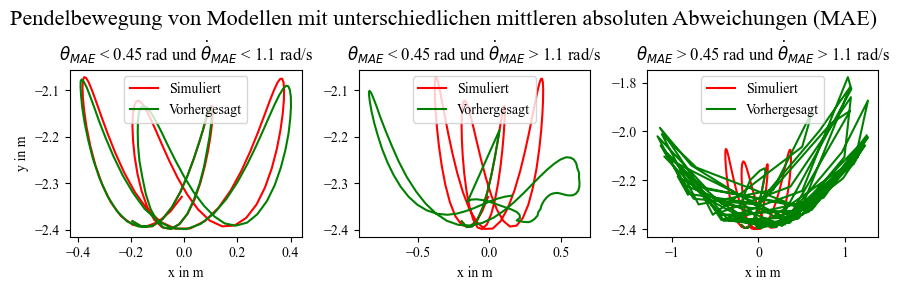

In [ ]:
# filename_model = 'mixed_initial_2000multi_inits_lagrange_MSE_1000x7'
filename_model ='mixed_6000_energy_conserv_700x8'
filename_model_threshold1 = 'multi_inits_absolute_energy_conserv_MSE_1000x7'
filename_model_threshold2 = '3layer_3000_epochs_multi_inits_absolute_energy'

filepath_excel = test1_params  # Ersetzen Sie dies durch Ihren tatsächlichen Pfad
filepath_excel_threshold1 = test1_params
filepath_excel_threshold2 = test1_params

titles = [
        r'$\theta_{MAE}$ < 0.45 rad und $\dot{\theta}_{MAE}$ < 1.1 rad/s',
        r'$\theta_{MAE}$ < 0.45 rad und $\dot{\theta}_{MAE}$ > 1.1 rad/s',
        r'$\theta_{MAE}$ > 0.45 rad und $\dot{\theta}_{MAE}$ > 1.1 rad/s'
    ]
plottitle = 'Pendelbewegung von Modellen mit unterschiedlichen mittleren absoluten Abweichungen (MAE)'

for j in range(0, 7):
    testcycle_filename_model = f'test_nr_{j+1}_{filename_model}.csv'
    testcycle_filename_model_threshold1 = f'test_nr_{j+1}_{filename_model_threshold1}.csv'
    testcycle_filename_model_threshold2 = f'test_nr_{j+1}_{filename_model_threshold2}.csv'

    full_path_excel = os.path.join(filepath_excel, testcycle_filename_model)
    full_path_excel_threshold1 = os.path.join(filepath_excel_threshold1, testcycle_filename_model_threshold1)
    full_path_excel_threshold2 = os.path.join(filepath_excel_threshold2, testcycle_filename_model_threshold2)

    try:
        # Excel-Datei laden
        df = pd.read_csv(full_path_excel)
        df_threshold1 = pd.read_csv(full_path_excel_threshold1)
        df_threshold2 = pd.read_csv(full_path_excel_threshold2)
        OneStep(df, df_threshold1, df_threshold2, titles, plottitle)

    except FileNotFoundError:
        print(f"Datei nicht gefunden: {full_path_excel}")

In [ ]:
def plot_boxplot(model_names, deviation_test1, deviation_test2, title, plot_size):

    # flattening the data
    flattened_test1 = [np.concatenate(dev) for dev in deviation_test1]
    flattened_test2 = [np.concatenate(dev) for dev in deviation_test2]

    plt.figure(figsize=plot_size)
    plt.rcParams.update({'font.size': 10, 'font.family': 'Times New Roman'})

    # Noxplot modifications
    boxprops_test1 = dict(facecolor='lightblue')
    boxprops_test2 = dict(facecolor='lightgreen')
    flierprops = dict(marker='o', markersize=3, markerfacecolor='red', alpha=0.5)  # Kleinere und transparentere Ausreißer

    # Boxplots for Theta and Omega
    plt.boxplot(flattened_test1, positions=np.arange(len(model_names)) * 2, widths=0.6, 
                patch_artist=True, boxprops=boxprops_test1, flierprops=flierprops)
    plt.boxplot(flattened_test2, positions=np.arange(len(model_names)) * 2 + 1, widths=0.6, 
                patch_artist=True, boxprops=boxprops_test2, flierprops=flierprops)

    # axis lables
    model_names_numbered = [f"{i+1}. {name}" for i, name in enumerate(model_names)]

    plt.xticks(np.arange(len(model_names)) * 2 + 0.5, model_names_numbered, rotation=45, ha='right')
    plt.ylabel('Abweichung')
    plt.title(title)

    # create legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=8, label='Test 1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=8, label='Test 2')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    # add gird
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()



In [ ]:
plottitle = 'Vergleich der Modelle zwischen Testdurchlauf 1 und 2 (versch.) Anfangsbedingungen'
plotsize = (9, 7)
plot_boxplot(Model_names, test1_initials_tested_theta, test2_initials_tested_theta, plottitle, plotsize)
plot_boxplot(Model_names, test1_initials_tested_omega, test2_initials_tested_omega, plottitle, plotsize)

plot_boxplot(Model_names, test1_params_tested_theta, test2_params_tested_theta, plottitle, plotsize)
plot_boxplot(Model_names, test1_params_tested_omega, test2_params_tested_omega, plottitle, plotsize)